In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

traindf = pd.read_csv('../input/pneumoniasized/labels_train.csv', dtype=str)
# path for the square images with black padding 
train_path = '../input/pneumoniasized/sized_train'

# Class_0 = Normal, Class_1 = Bacterial-Pneumonia, Class_2 = Viral-Pneumonia
# Splitting the main dataframe into smaller class spesific dataframes 
class_0=traindf.loc[traindf.class_id == '0']
class_0.reset_index(drop=True,inplace=True)
class_1=traindf.loc[traindf.class_id == '1']
class_1.reset_index(drop=True,inplace=True)
class_2=traindf.loc[traindf.class_id == '2']
class_2.reset_index(drop=True,inplace=True)

# Combining a portion of our class dataframes into one dataframe for training, maintaining the distribution 
train = class_0[:920]
train = train.append(class_1[:1678])
train = train.append(class_2[:905])
train.reset_index(drop=True,inplace=True)

# Combining the rest of our class dataframes into one dataframe for testing
test = class_0[920:]
test = test.append(class_1[1678:])
test = test.append(class_2[905:])
test.reset_index(drop=True,inplace=True)

# Define the number of splits for cross-validation
split_num = 3
kfold = StratifiedKFold(n_splits=split_num, shuffle=True)

VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

(array([ 920., 1678.,  905.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

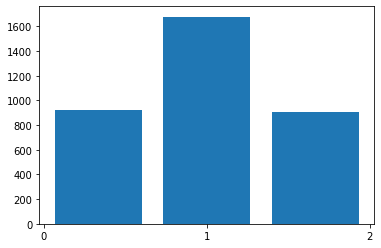

In [7]:
from matplotlib import pyplot as plt

# Visualizing the distribution of our dataset
plt.hist(train['class_id'],rwidth=0.8, bins=3, histtype='bar', label='Classes Distribution')

Text(0.5, 1.0, '2')

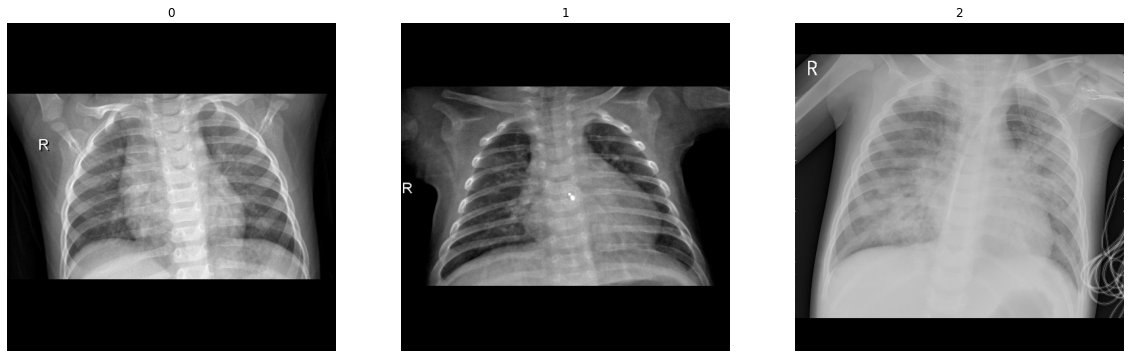

In [8]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

path='../input/pneumoniasized/sized_train/'

fig = plt.figure(figsize=(20, 20))
  
# setting values to rows and column variables
rows = 1
columns = 3

# image indexes to select
index_1=0
index_2=1700
index_3=3200
  
# reading images
Image1 = cv2.imread(path+train.iloc[index_1][0],1)
Image1_label = train.iloc[index_1][1]
Image2 = cv2.imread(path+train.iloc[index_2][0],1)
Image2_label = train.iloc[index_2][1]
Image3 = cv2.imread(path+train.iloc[index_3][0],1)
Image3_label = train.iloc[index_3][1]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing normal case image 
plt.imshow(Image1)
plt.axis('off')
plt.title(Image1_label)
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing bacterial pneumonia image
plt.imshow(Image2)
plt.axis('off')
plt.title(Image2_label)
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing viral pneumonia image
plt.imshow(Image3)
plt.axis('off')
plt.title(Image3_label)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, average
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.initializers import *
from tensorflow.keras.applications.efficientnet import preprocess_input

img_size = 300

# Creates and returns an EfficientNetB3 model with different classification layers
def create_model(input_shape, n_classes):
    
    # Input and preprocess needed for EfficientNetB3
    inputs = Input(input_shape)
    prep = preprocess_input(inputs)

    # EfficientNetB3 without top classification layers
    conv_base = EfficientNetB3(include_top=False,
                            weights='imagenet',
                            input_tensor=prep)
    conv_base.trainable=False

    # Top classification layers        
    top_model = GlobalAveragePooling2D()(conv_base.output)
    top_model = Dense(512, activation='relu', kernel_initializer="glorot_normal")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(128, activation='relu', kernel_initializer="glorot_normal")(top_model)
    output = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs, output)
    
    return model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, average
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import *
from tensorflow.keras.applications.densenet import preprocess_input

img_size = 224

# Creates and returns a DenseNet121 model with different top classification layers
def create_model(input_shape, n_classes):
    
    # Input and preprocess needed for DenseNet201
    inputs = Input(input_shape)
    prep = preprocess_input(inputs)

    # DenseNet201 without top classification layers and trainable weights
    conv_base = DenseNet201(include_top=False,
                            weights='imagenet',
                            input_tensor=prep)

    # Top classification layers      
    top_model = GlobalAveragePooling2D()(conv_base.output)
    top_model = Dense(512, activation='relu', kernel_initializer="glorot_normal")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(128, activation='relu', kernel_initializer="glorot_normal")(top_model)
    output = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs, output)
    
    return model

In [ ]:
from tensorflow.keras.utils import plot_model

# Dummy model for visualization 
model = create_model((100,100,3), 3)
plot_model(model)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Different ImageDataGenerators for train and validation batches without live augmentaion
tdatagen = ImageDataGenerator()
vdatagen = ImageDataGenerator()  

Found 2335 validated image filenames belonging to 3 classes.
Found 1168 validated image filenames belonging to 3 classes.


2022-02-15 20:32:37.815673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 20:32:37.919943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 20:32:37.920706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 20:32:37.922059: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 1s 0us/step
------------------------------------------------------------------------
Training for fold 1 ...
Class weights: {0: 1.2697117998912453, 1: 0.6955615132558832, 2: 1.2907683803206191}


2022-02-15 20:32:45.715823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-02-15 20:33:03.578397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


234/234 [==============================] - 76s 219ms/step - loss: 0.5939 - accuracy: 0.7383 - val_loss: 0.6372 - val_accuracy: 0.7851

Epoch 00001: val_accuracy improved from -inf to 0.78510, saving model to model_1.h5
Epoch 2/7
234/234 [==============================] - 43s 182ms/step - loss: 0.4647 - accuracy: 0.8039 - val_loss: 0.5944 - val_accuracy: 0.7551

Epoch 00002: val_accuracy did not improve from 0.78510
Epoch 3/7
234/234 [==============================] - 42s 179ms/step - loss: 0.3761 - accuracy: 0.8385 - val_loss: 0.6414 - val_accuracy: 0.7012

Epoch 00003: val_accuracy did not improve from 0.78510
Epoch 4/7
1e-05
234/234 [==============================] - 42s 180ms/step - loss: 0.2346 - accuracy: 0.8955 - val_loss: 0.4202 - val_accuracy: 0.8442

Epoch 00004: val_accuracy improved from 0.78510 to 0.84418, saving model to model_1.h5
Epoch 5/7
1e-05
234/234 [==============================] - 42s 180ms/step - loss: 0.1646 - accuracy: 0.9345 - val_loss: 0.4501 - val_accuracy: 

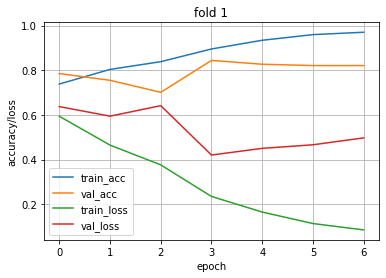

117/117 [==============================] - 8s 68ms/step - loss: 0.4202 - accuracy: 0.8442
Found 2335 validated image filenames belonging to 3 classes.
Found 1168 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 2 ...
Class weights: {0: 1.2697117998912453, 1: 0.6955615132558832, 2: 1.2907683803206191}
Epoch 1/7
234/234 [==============================] - 62s 193ms/step - loss: 0.6070 - accuracy: 0.7225 - val_loss: 0.5355 - val_accuracy: 0.8014

Epoch 00001: val_accuracy improved from -inf to 0.80137, saving model to model_2.h5
Epoch 2/7
234/234 [==============================] - 43s 184ms/step - loss: 0.4382 - accuracy: 0.8056 - val_loss: 0.4724 - val_accuracy: 0.8091

Epoch 00002: val_accuracy improved from 0.80137 to 0.80908, saving model to model_2.h5
Epoch 3/7
234/234 [==============================] - 43s 183ms/step - loss: 0.3407 - accuracy: 0.8501 - val_loss: 0.6238 - val_accuracy: 0.7123



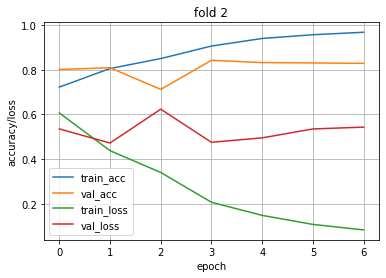

117/117 [==============================] - 8s 69ms/step - loss: 0.4756 - accuracy: 0.8425
Found 2336 validated image filenames belonging to 3 classes.
Found 1167 validated image filenames belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 3 ...
Class weights: {0: 1.268186753528773, 1: 0.6964818127608825, 2: 1.2891832229580573}
Epoch 1/7
234/234 [==============================] - 64s 203ms/step - loss: 0.6138 - accuracy: 0.7247 - val_loss: 0.4924 - val_accuracy: 0.8055

Epoch 00001: val_accuracy improved from -inf to 0.80548, saving model to model_3.h5
Epoch 2/7
234/234 [==============================] - 43s 182ms/step - loss: 0.4703 - accuracy: 0.8035 - val_loss: 0.7594 - val_accuracy: 0.7009

Epoch 00002: val_accuracy did not improve from 0.80548
Epoch 3/7
234/234 [==============================] - 42s 180ms/step - loss: 0.3838 - accuracy: 0.8330 - val_loss: 0.4849 - val_accuracy: 0.8003

Epoch 00003: val_accuracy did not

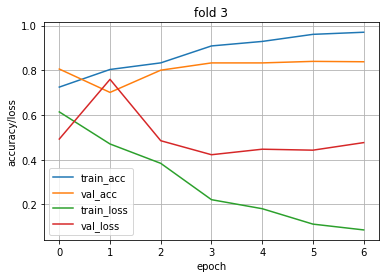

117/117 [==============================] - 7s 63ms/step - loss: 0.4426 - accuracy: 0.8398


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.backend import clear_session
from matplotlib import pyplot as plt

save_dir = './'
fold_no = 1
batch_size = 10
n_classes = 3
n_epochs = 7
fold_no = 1
input_shape=(img_size,img_size,3)


# Splitting image names and labels for kfold cross-validation
imgs = train[['file_name']]
labels = train[['class_id']]

# Returns current fold's model
def get_model_name(num):
    return 'model_'+str(num)+'.h5'

# Training with stratified k-fold cross-validation
for train_index, val_index in kfold.split(imgs,labels):

    # Creating current fold dataframes for training and validation
    fold_train_df = train.iloc[train_index]
    fold_valid_df = train.iloc[val_index]
    
    # Creating train and validation batches using the ImageDataGenerators and the dataframes we created previously
    train_batches = tdatagen.flow_from_dataframe(fold_train_df, 
                                                directory=train_path,
                                                x_col="file_name", 
                                                y_col="class_id",
                                                batch_size=batch_size, 
                                                class_mode="categorical", 
                                                target_size=(img_size,img_size))

    valid_batches = vdatagen.flow_from_dataframe(fold_valid_df, 
                                                directory=train_path,
                                                x_col="file_name", 
                                                y_col="class_id",
                                                batch_size=batch_size, 
                                                class_mode="categorical", 
                                                target_size=(img_size,img_size))

    # Creating the model with our top classification layers  
    model = create_model(input_shape, n_classes)
    model._name="model_"+str(fold_no)

    # Compiling the model with chosen optimizer, loss and metrics
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #-----------------------callbacks----------------------------
    from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

    # Returns leraning rate based on epoch
    def scheduler(epoch, lr):
        if epoch > 2:
            lr=1e-5
            print(lr)
            return lr
        else:
            return lr
        
    lr_scheduler = LearningRateScheduler(scheduler)

    # Saves best model of every fold based on minimum validation loss
    model_checkpoint= ModelCheckpoint(filepath="model_"+str(fold_no)+".h5",
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      verbose=1)
    # List of all our callbacks
    callbacks_list= [model_checkpoint,lr_scheduler]
    #-----------------------callbacks----------------------------
    
    # Creates balanced class weights 
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_batches.classes), y=train_batches.classes)
    cw = dict(zip(np.unique(train_batches.classes), weights))
    print('Class weights: ' + str(cw))
    
    # Training using train and validation batches, our callbacks and class weights
    history = model.fit(train_batches,
                        epochs=n_epochs,
                        validation_data=valid_batches,
                        callbacks=callbacks_list,
                        class_weight=cw,
                        verbose=1)  
    
    # Plot of current's fold accuracy, loss, validation accuracy and validation loss
    %matplotlib inline
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('fold '+str(fold_no))
    plt.ylabel('accuracy/loss')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='best')
    plt.grid(visible=True)
    plt.show()  

    model.load_weights("./model_"+str(fold_no)+".h5")
    
    # Fold's saved model evaluation on current's fold validation set
    results = model.evaluate(valid_batches) 
    results = dict(zip(model.metrics_names,results))

    # Appending the results of the fold 
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDAITON_LOSS.append(results['loss'])  

    clear_session()
    fold_no += 1 

In [6]:
from statistics import mean
from tensorflow.keras.models import load_model

# Mean of all the folds
print(mean(VALIDATION_ACCURACY))
print(mean(VALIDAITON_LOSS))

nets = split_num
models = [0] *nets

# List with all the fold models
for j in range(nets):
    models[j] = load_model("./model_"+str(j+1)+".h5")

0.8421346346537272
0.4461292227109273


In [7]:
# Creates and returns the average ensemble model of all the folds
def ensemble(models, model_input):
    
    Models_output=[model(model_input) for model in models]
    Avg = average(Models_output)
    
    modelEnsemble = Model(inputs=model_input, outputs=Avg, name='ensemble')
    modelEnsemble.compile(Adam(learning_rate=1e-5), 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
    modelEnsemble.summary()
    
    return modelEnsemble

# Input layer for the ensemble
model_input = Input(shape=models[0].input_shape[1:])
# Creates the ensemble model
ensemble_model = ensemble(models, model_input)

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 3)            19371587    input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 3)            19371587    input_1[0][0]                    
__________________________________________________________________________________________________
model_3 (Functional)            (None, 3)            19371587    input_1[0][0]                    
___________________________________________________________________________________________

Found 1169 validated image filenames belonging to 3 classes.
model_1
117/117 [==============================] - 15s 99ms/step - loss: 0.4352 - accuracy: 0.8186
model_2
117/117 [==============================] - 11s 66ms/step - loss: 0.4308 - accuracy: 0.8315
model_3
117/117 [==============================] - 11s 64ms/step - loss: 0.4266 - accuracy: 0.8460
average ensemble
117/117 [==============================] - 24s 125ms/step


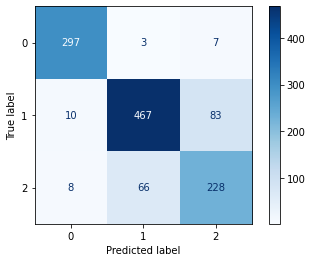

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# ImageDataGenerator without augmentaions for testing
test_datagen = ImageDataGenerator()

# Test batches with test ImageDataGenerator using our test dataframe
test_batches = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=train_path,
    x_col='file_name',
    y_col='class_id',
    batch_size=10,
    class_mode='categorical',
    shuffle=False,
    target_size=(img_size,img_size)
)

# loading and evaluating all our fold models on the test data
for j in range(nets):
    models[j] = load_model("./model_"+str(j+1)+".h5")
    print("model_"+str(j+1))
    models[j].evaluate(test_batches)

# evaluating the average ensemble model on the test data    
print("average ensemble")
results = ensemble_model.evaluate(test_batches)
predictions = ensemble_model.predict(test_batches,verbose=1)

# plotting a confusion matrix from the ensemble model predictions
cm = confusion_matrix(test_batches.classes, np.argmax(predictions, axis=-1))
labels = ['0','1','2']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       307
           1       0.87      0.83      0.85       560
           2       0.72      0.75      0.74       302

    accuracy                           0.85      1169
   macro avg       0.84      0.85      0.85      1169
weighted avg       0.85      0.85      0.85      1169



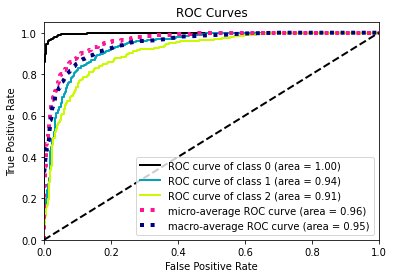

In [9]:
from sklearn import metrics
import scikitplot as skplt

# ensemble model classification report with precision, recall, f1-score and accuracy
y = np.argmax(predictions, axis=-1)
cr = classification_report(y_true=test_batches.classes, y_pred=y, target_names=test_batches.class_indices)
print(cr)

# roc curves of all the classes
skplt.metrics.plot_roc(test_batches.classes, predictions)
plt.show()

In [ ]:
import os
from tensorflow.keras.models import load_model

test_datagen = ImageDataGenerator()
test_path = '../input/pneumonia/sized/sized_test_df'
test_images = []

i=1
for img in os.listdir(test_path):
    test_images.append(img)
    i+=1
   
submision = pd.DataFrame(test_images,columns=['file_name'])

test_batches = test_datagen.flow_from_dataframe(
    dataframe=submision,
    directory=test_path,
    x_col="file_name",
    batch_size=10,
    class_mode=None,
    shuffle=False,
    target_size=(img_size,img_size)
)

predictions = ensemble_model.predict(test_batches,verbose=1)

preds = np.argmax(predictions, axis=-1) 
print(preds)

submision['class_id'] = preds
submision.to_csv('submision32.csv',index=False)